# BioImage model training on 2D images

In [1]:
import matplotlib.pyplot as plt
import zarr
import dask
import dask.array as da
import numpy as np
import bioimageio.core
from bioimageio.core import Tensor, Sample, create_prediction_pipeline
from bioimageio.spec.utils import load_array
from dask import delayed
import imageio
from tifffile import imread
from mpl_toolkits.mplot3d import Axes3D
import torch
from skimage import io
import plotly
import plotly.express as px

In [2]:
# Function to handle model inference
def run_model_inference(bmz_model, arr):
    # load model
    model_resource = bioimageio.core.load_description(bmz_model)

    # load model's test input image
    test_input_image = load_array(model_resource.inputs[0].test_tensor)

    # match test data type with the data type of the model input
    arr = arr.astype(test_input_image.dtype)

    # create input tensor
    input_tensor = Tensor.from_numpy(arr, dims=tuple(model_resource.inputs[0].axes))

    # create collection of tensors (sample)
    inp_id = model_resource.inputs[0].id
    outp_id = model_resource.outputs[0].id
    sample = Sample(members={inp_id: input_tensor}, stat={}, id="id")

    # The prediction_pipeline function is used to run a prediction with a given model
    # It applies the pre-processing, if indicated in the model rdf.yaml,
    # runs inference with the model and applies the post-processing, again if specified in the model rdf.yaml.
    prediction_pipeline = create_prediction_pipeline(model_resource)

    # Use the new prediction pipeline to run a prediction. The prediction pipeline returns a Sample object
    prediction = prediction_pipeline.predict_sample_without_blocking(sample)

    return prediction, sample, inp_id, outp_id

In [ ]:
#Download your model
bmz_model_id = bioimageio.core.load_description('./affable-shark/rdf.yaml') #path to your model; you need to download the folder with model from website 

In [4]:
#Look at slises in your image
my_image3D = io.imread('./BDS3_2025_data/MXT/2015.01.17_MTX_1h-1h_S_I_Pos001_S001_0_C2.tif')

upper_limit = 1.5 * np.percentile(my_image3D, q=99)
my_image3D = np.clip(my_image3D, 0, upper_limit)

fig = px.imshow(
    my_image3D,
    animation_frame=0,
    binary_string=True,
    binary_format="tif",
)
plotly.io.show(fig)

In [5]:
#Choose a test plane from your image
image = io.imread('./BDS3_2025_data/MXT/2015.01.17_MTX_1h-1h_S_I_Pos001_S001_0_C2.tif')
test_plane = image [41, :, :] #choose slide
print(f"input image shape: {test_plane.shape}")

input image shape: (512, 512)


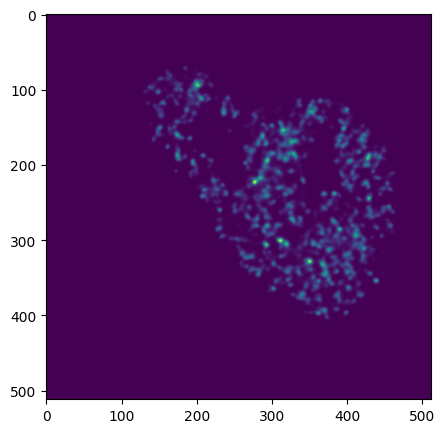

In [6]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(test_plane)

Test chosen segmentation model

In [7]:
%time 
prediction, sample, inp_id, outp_id = run_model_inference(bmz_model_id, test_plane)

2025-08-18 13:57:40.902 | WARNING  | bioimageio.spec._io:load_description:84 - returning already loaded description 'Nuclei Segmentation Boundary Model' as is


CPU times: user 2 μs, sys: 1 μs, total: 3 μs
Wall time: 7.15 μs


Measuring the results of deep learning models:

In [8]:
pred_array1 = np.asarray(prediction.members[outp_id].data)
print(f"prediction shape: {pred_array1.shape}")

prediction shape: (1, 2, 512, 512)


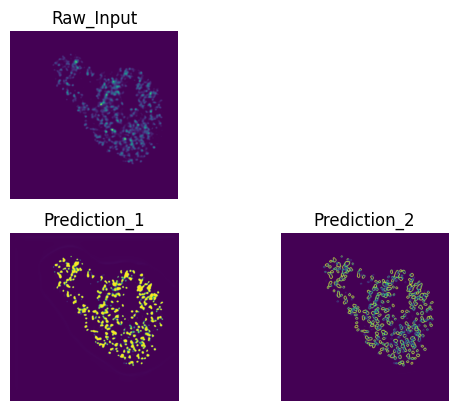

In [9]:
ax1 = plt.subplot(2, 2, 1)
ax1.set_title("Raw_Input")
ax1.axis("off")
plt.imshow(test_plane)

ax2 = plt.subplot(2, 2, 3)
ax2.set_title("Prediction_1")
ax2.axis("off")
plt.imshow(pred_array1[0, 0, :, :])

ax2 = plt.subplot(2, 2, 4)
ax2.set_title("Prediction_2")
ax2.axis("off")
plt.imshow(pred_array1[0, 1, :, :])

In [10]:
print(f"Prediction data type: {pred_array1.dtype}") #Type of data received

Prediction data type: float32


In [11]:
binary_pred1 = pred_array1[0, 0, :, :] >= 0.5 #Set threshold values for the prediction results
print(binary_pred1.shape)

(512, 512)


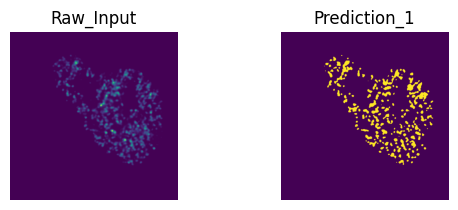

In [12]:
#Mask
ax1 = plt.subplot(2, 2, 1)
ax1.set_title("Raw_Input")
ax1.axis("off")
plt.imshow(test_plane)

ax2 = plt.subplot(2, 2, 2)
ax2.set_title("Prediction_1")
ax2.axis("off")
plt.imshow(binary_pred1[:, :])


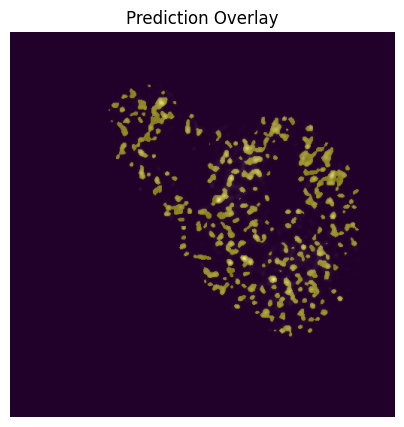

In [13]:
#Overlay
plt.figure(figsize=(5, 5))
plt.title("Prediction Overlay")
plt.axis("off")  # Ukrycie osi
plt.imshow(test_plane, cmap="grey")  # Base image
plt.imshow(binary_pred1, alpha=0.5)  # Overlay z przezroczystością
plt.show()